### Import all required libraries

In [1]:
#! pip install xgboost
#! pip install graphviz
# ! pip install --upgrade pip


In [43]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score

import xgboost as xgb


import graphviz
import graphviz.dot as dot

### Load dataset

Since this dataset is from Kaggle, it will require Kaggle API to able to download 

In [3]:
# You will  need kaggle api to download the dataset
# you will also need to uncomment and run the following line the first time if you dont have the dataset
#  ! pip install kaggle
# ! mkdir -p ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json



In [4]:
# ! kaggle datasets download -d shubhambathwal/flight-price-prediction

In [5]:
# from zipfile import ZipFile
# filename = 'flight-price-prediction.zip'
# with ZipFile(filename, 'r') as zip:
#     zip.extractall()
#     print('Done!')

In [6]:
df = pd.read_csv('Clean_Dataset.csv')
df.head(20)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
5,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
6,6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
7,7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060
8,8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
9,9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954


In [7]:
df.shape

(300153, 12)

In [8]:
#dropping the unnamed: 0 column
df = df.drop(columns=['Unnamed: 0'])

In [9]:
# quick information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [10]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [11]:
#check N/A values
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [12]:
df.describe(include='all')


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


<Axes: xlabel='price'>

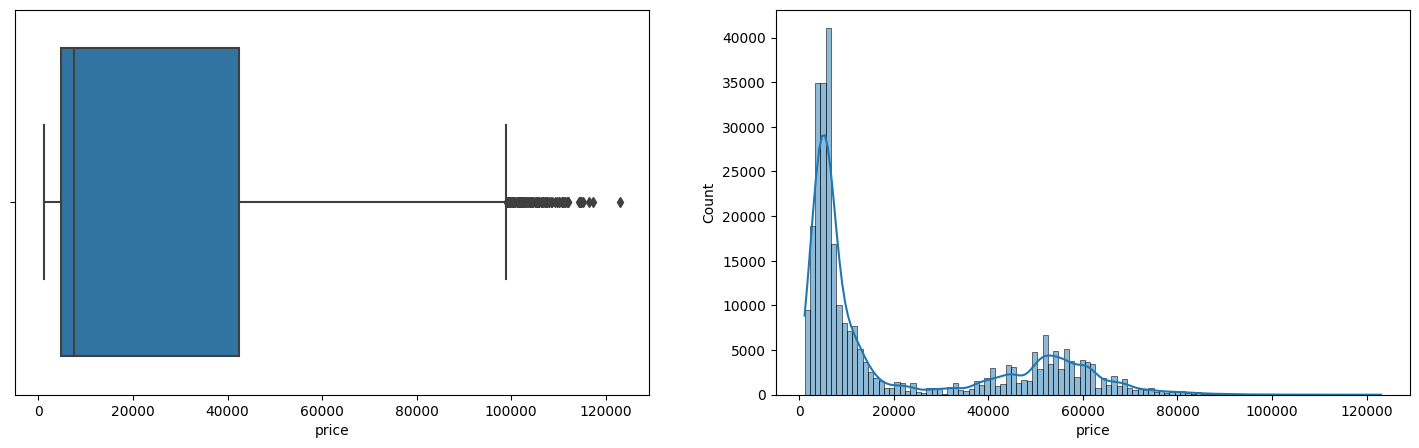

In [13]:

plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

In [14]:
#  pairwise correlation of 3 columns duration, days left and price
df[['duration', 'days_left', 'price']].corr().T


,duration,days_left,price
duration,1.000000,-0.039157,0.204222
days_left,-0.039157,1.000000,-0.091949
price,0.204222,-0.091949,1.000000


In [15]:
df['airline'].value_counts()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

[Text(0, 0, 'Vistara'),
 Text(1, 0, 'Air_India'),
 Text(2, 0, 'Indigo'),
 Text(3, 0, 'GO_FIRST'),
 Text(4, 0, 'AirAsia'),
 Text(5, 0, 'SpiceJet')]

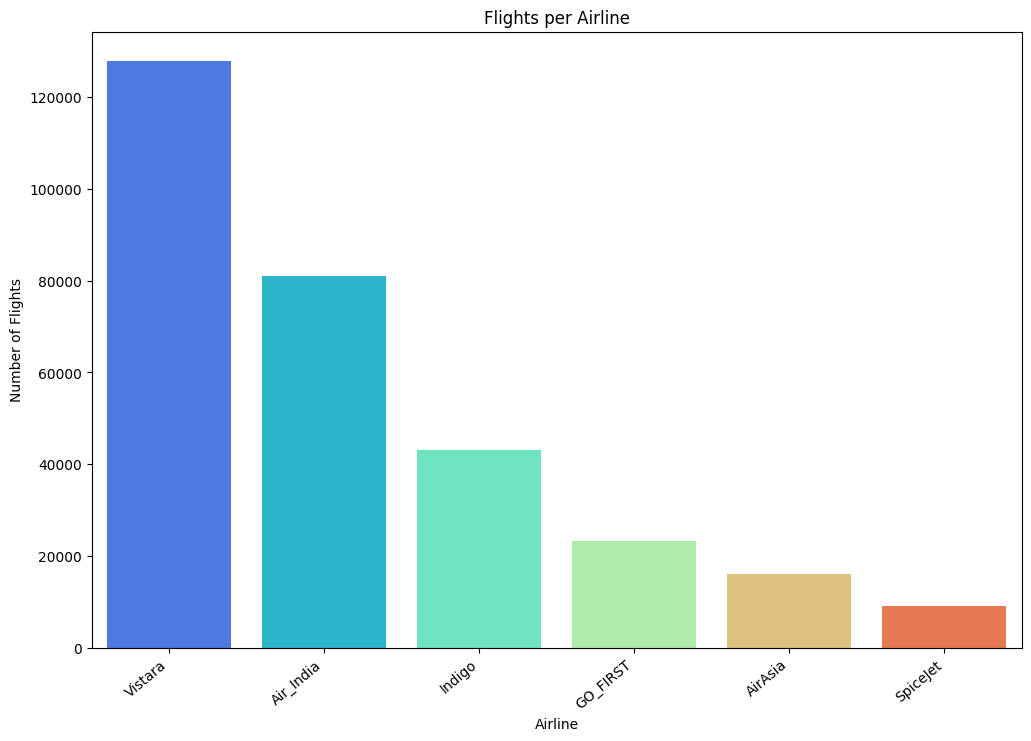

In [16]:
# plot the number of flights per airline
fig, ax = plt.subplots(figsize=(12, 8))
airline_counts = df.airline.value_counts()
ax = sns.barplot(x=airline_counts.index, y=airline_counts.values, palette='rainbow')

ax.set(xlabel='Airline', 
       ylabel='Number of Flights',
       title='Flights per Airline')
       

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [46]:
class_counts = df['class'].value_counts()
class_counts

class
0    206666
1     93487
Name: count, dtype: int64

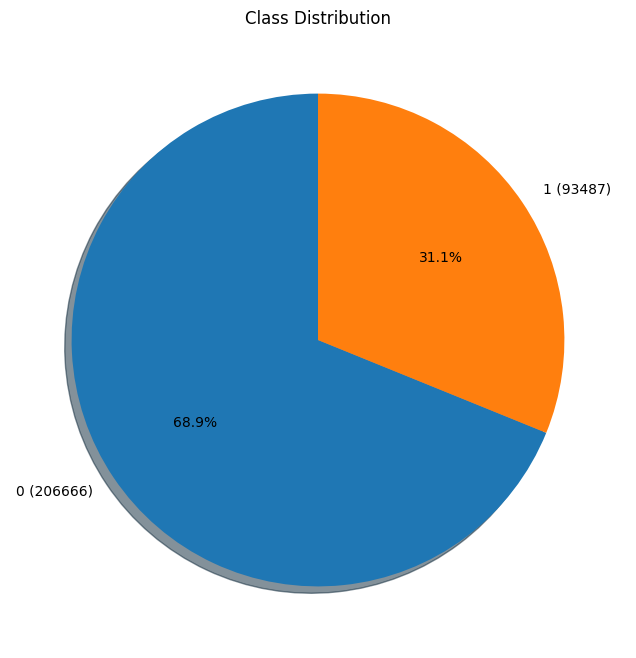

In [47]:
#pie chart for class distribution
data = df['class'].value_counts()
labels = [f"{c} ({n})" for c, n in zip(class_counts.index, class_counts.values)]
plt.figure(figsize=(12,8))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution')
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'labels'

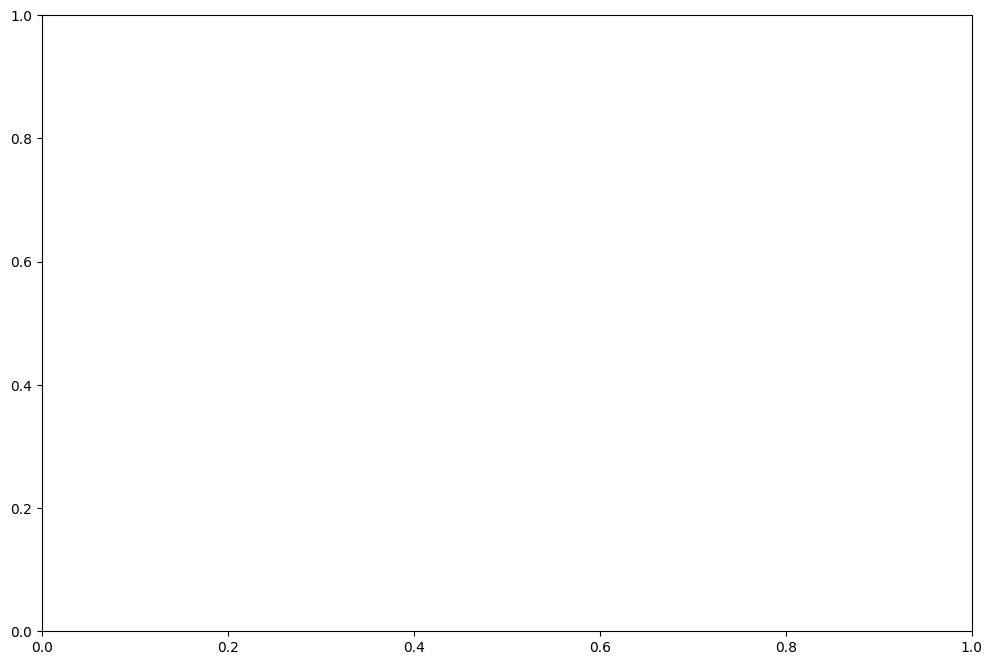

In [44]:
# price vary with different airlines and class
plt.figure(figsize=(12,8))
sns.barplot(x='airline', y='price', hue='class', data=df)
plt.title('Price vs Airline')
plt.show()


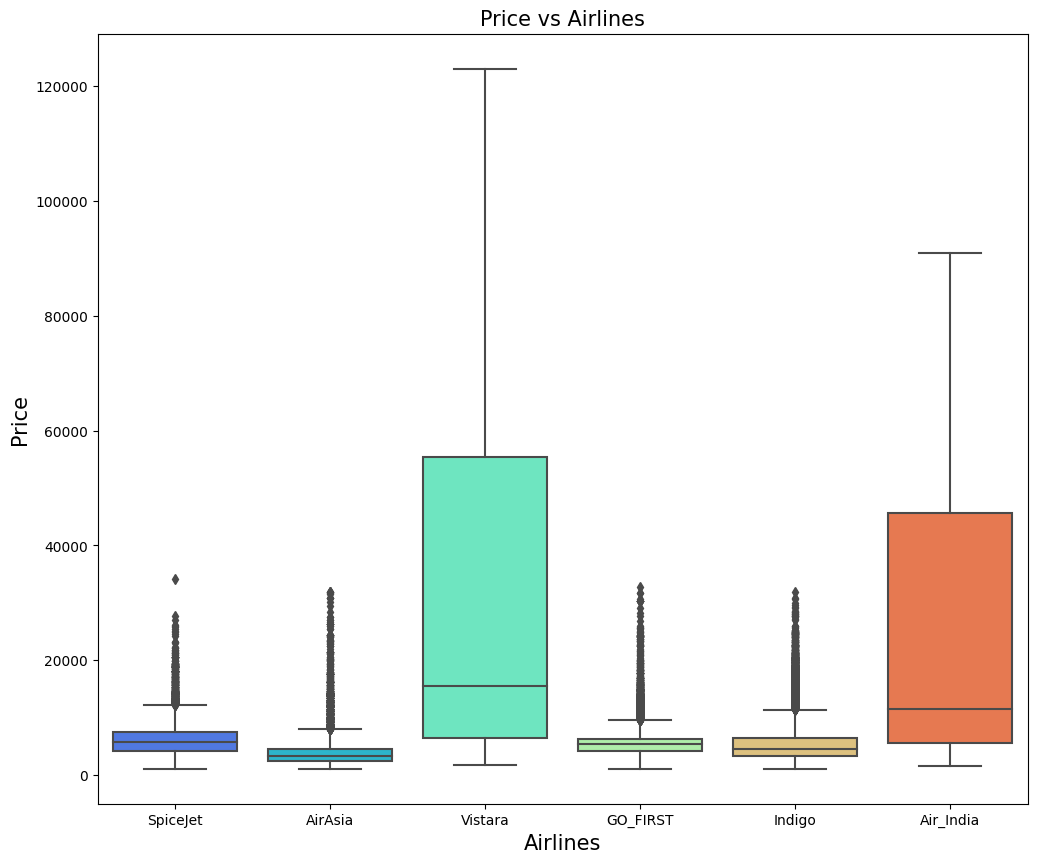

In [20]:
# price vary with different airlines
plt.figure(figsize=(12,10))
sns.boxplot(x='airline',y='price',data=df, palette='rainbow')
plt.title('Price vs Airlines',fontsize=15)
plt.xlabel('Airlines',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

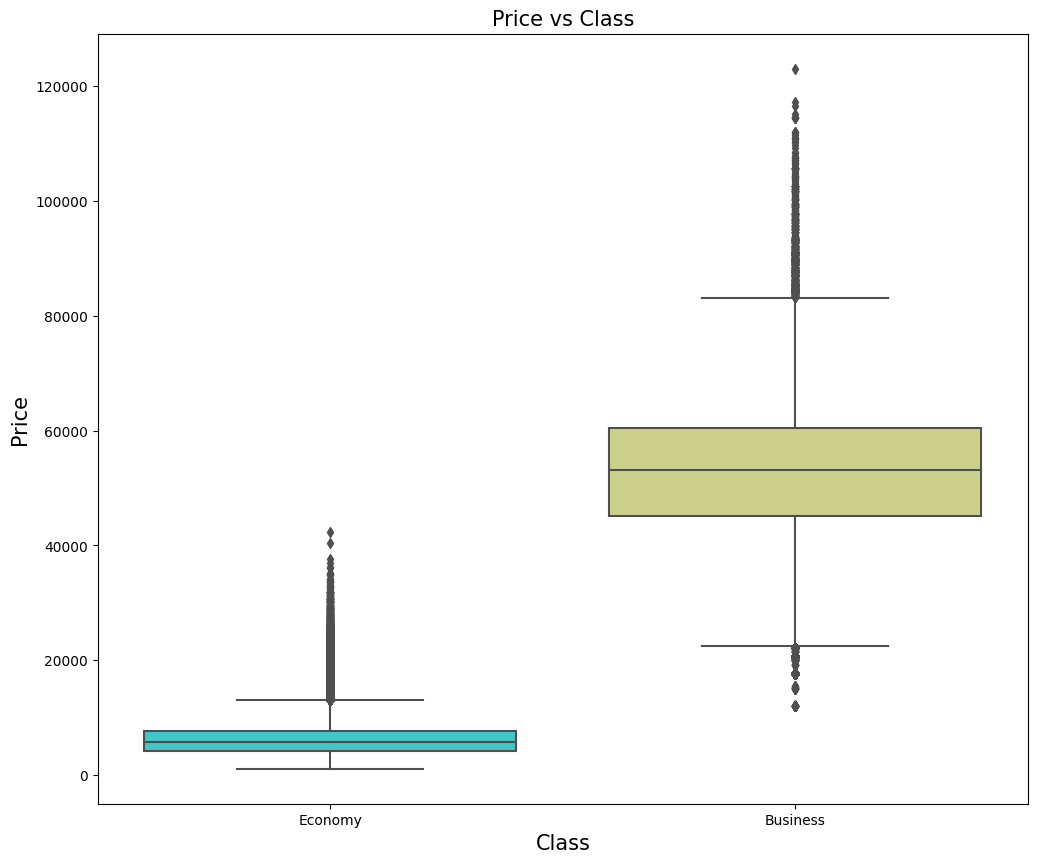

In [21]:
# price vary with different classes
plt.figure(figsize=(12,10))
sns.boxplot(x='class',y='price',data=df, palette='rainbow')
plt.title('Price vs Class',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

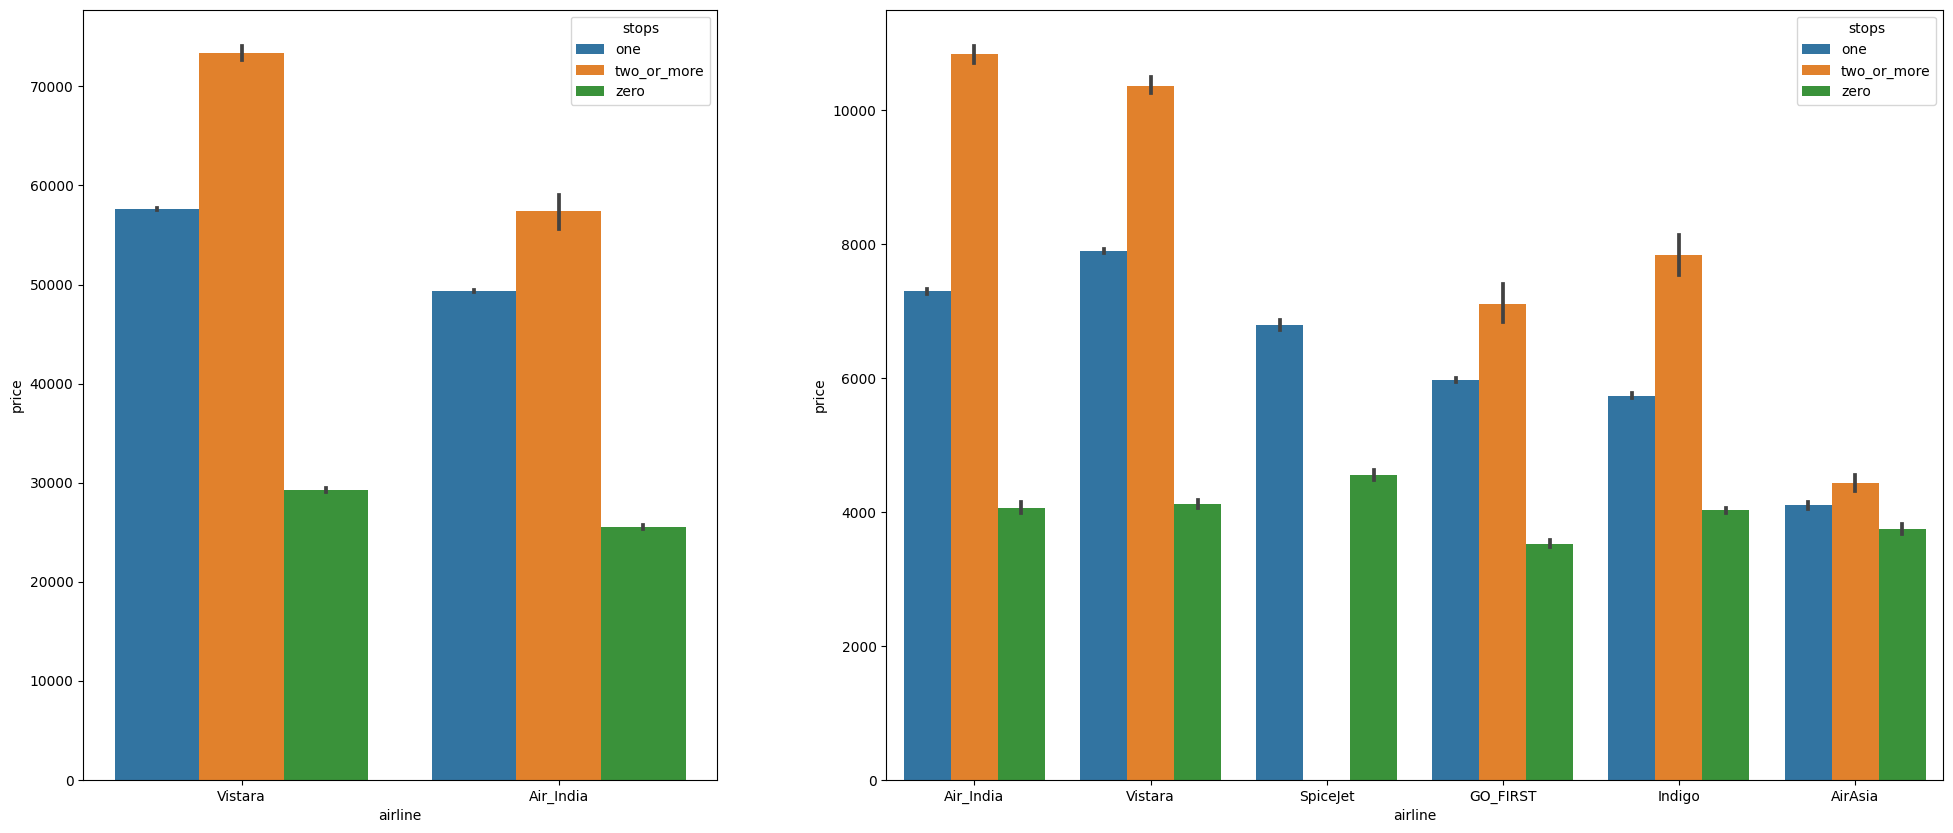

In [22]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 5]},figsize=(24,10))

# Plot on axes 1 
sns.barplot(x='airline', y='price', hue='stops', 
            data=df.loc[df['class']=='Business'].sort_values('price', ascending=False),
            ax=ax1)

# Plot on axes 2
sns.barplot(x='airline', y='price', hue='stops',
            data=df.loc[df['class']=='Economy'].sort_values('price', ascending=False), 
            ax=ax2)

plt.show()


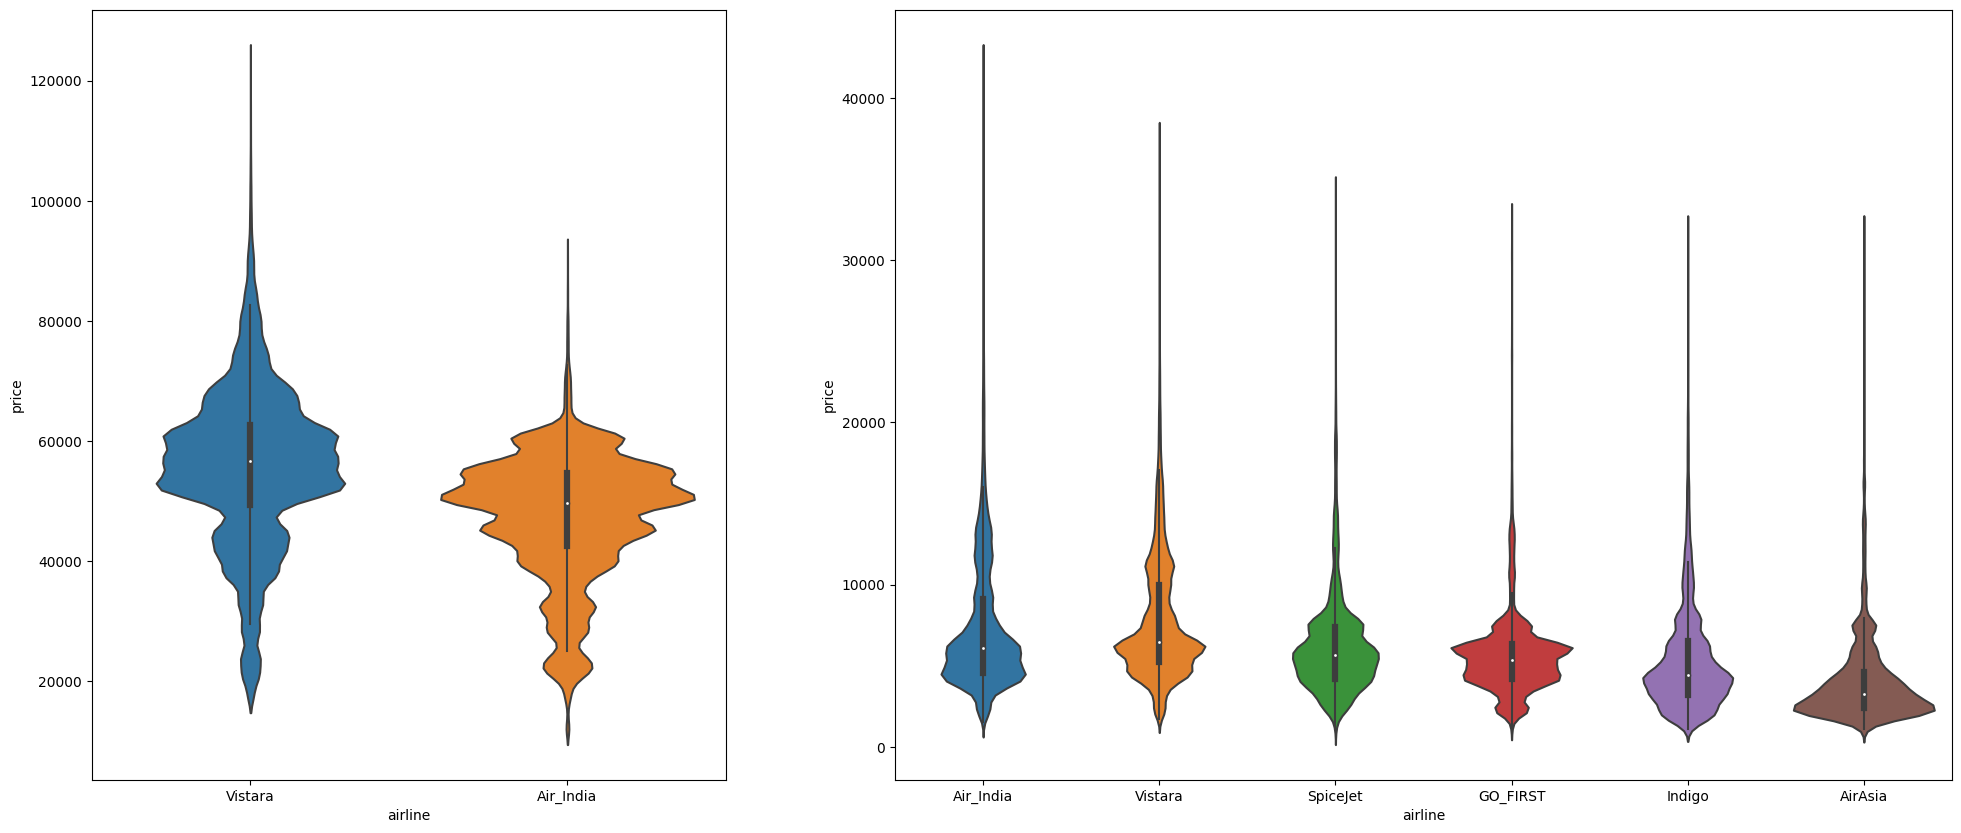

In [23]:
# price vary with different airlines and class with violin plot
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 5]},figsize=(24,10))

# Plot on axes 1 
sns.violinplot(x='airline', y='price', 
            data=df.loc[df['class']=='Business'].sort_values('price', ascending=False),
            ax=ax1)

# Plot on axes 2
sns.violinplot(x='airline', y='price',
            data=df.loc[df['class']=='Economy'].sort_values('price', ascending=False), 
            ax=ax2)

plt.show()


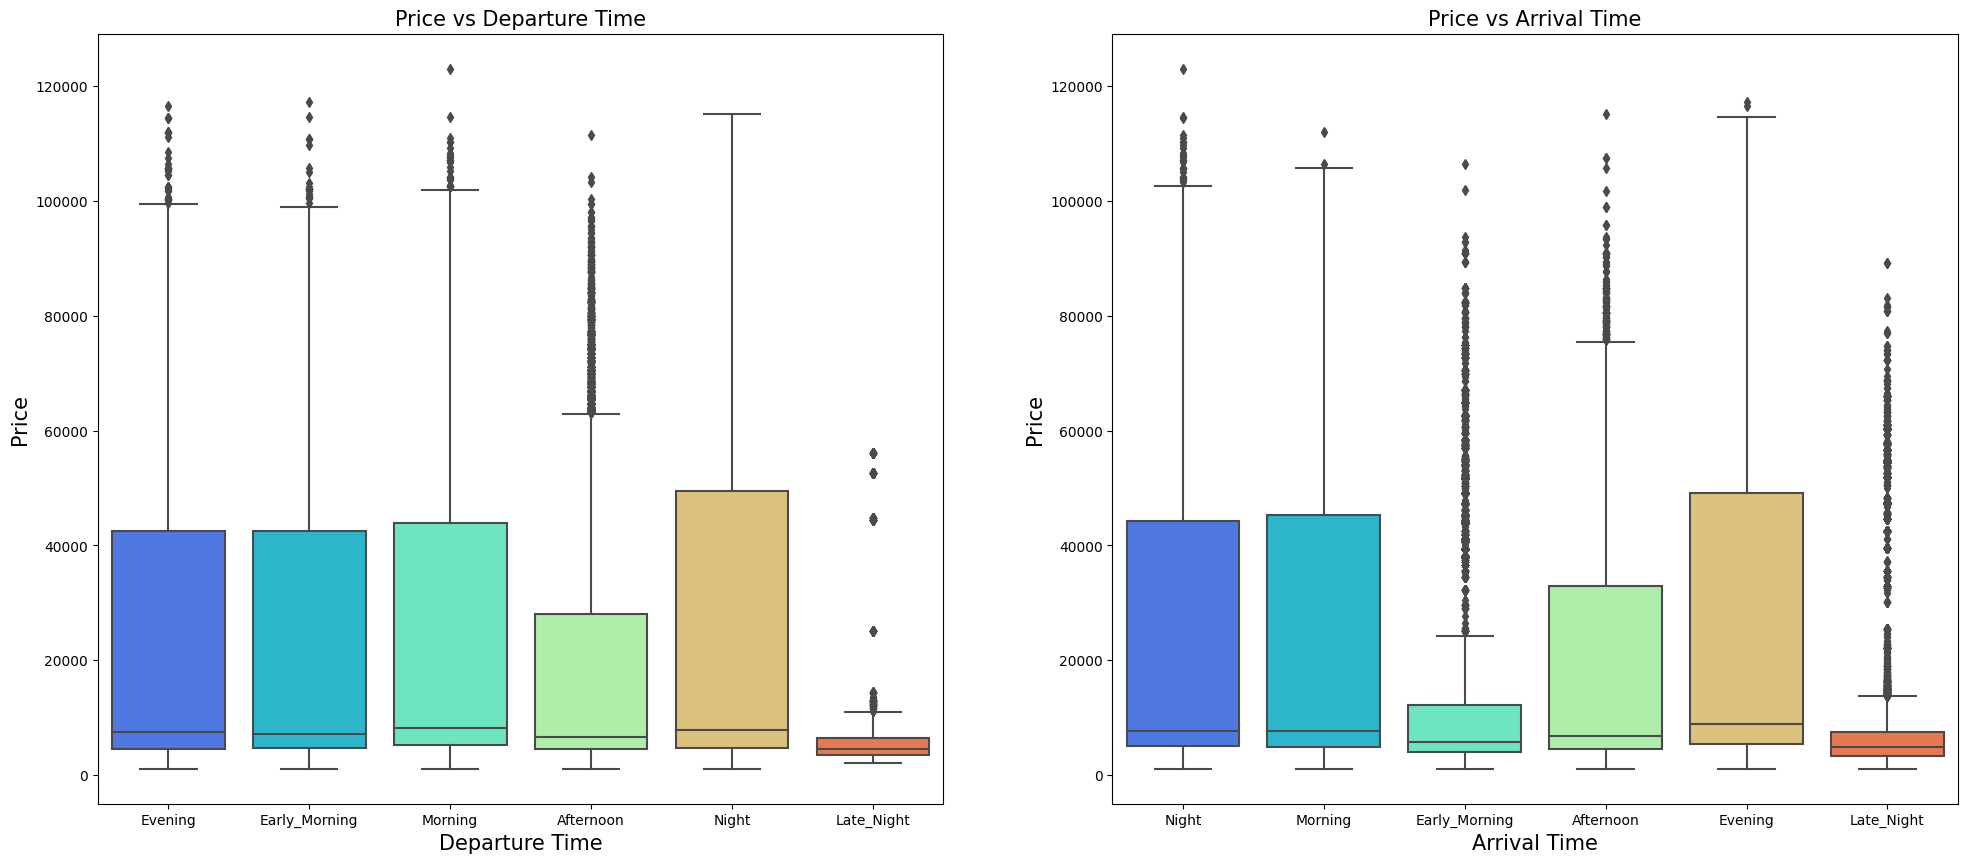

In [24]:
# price vary with different Departure time and Arrival time
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='departure_time',y='price',data=df, palette='rainbow')
plt.title('Price vs Departure Time',fontsize=15)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='arrival_time',y='price',data=df, palette='rainbow')
plt.title('Price vs Arrival Time',fontsize=15)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<Figure size 2400x1000 with 0 Axes>

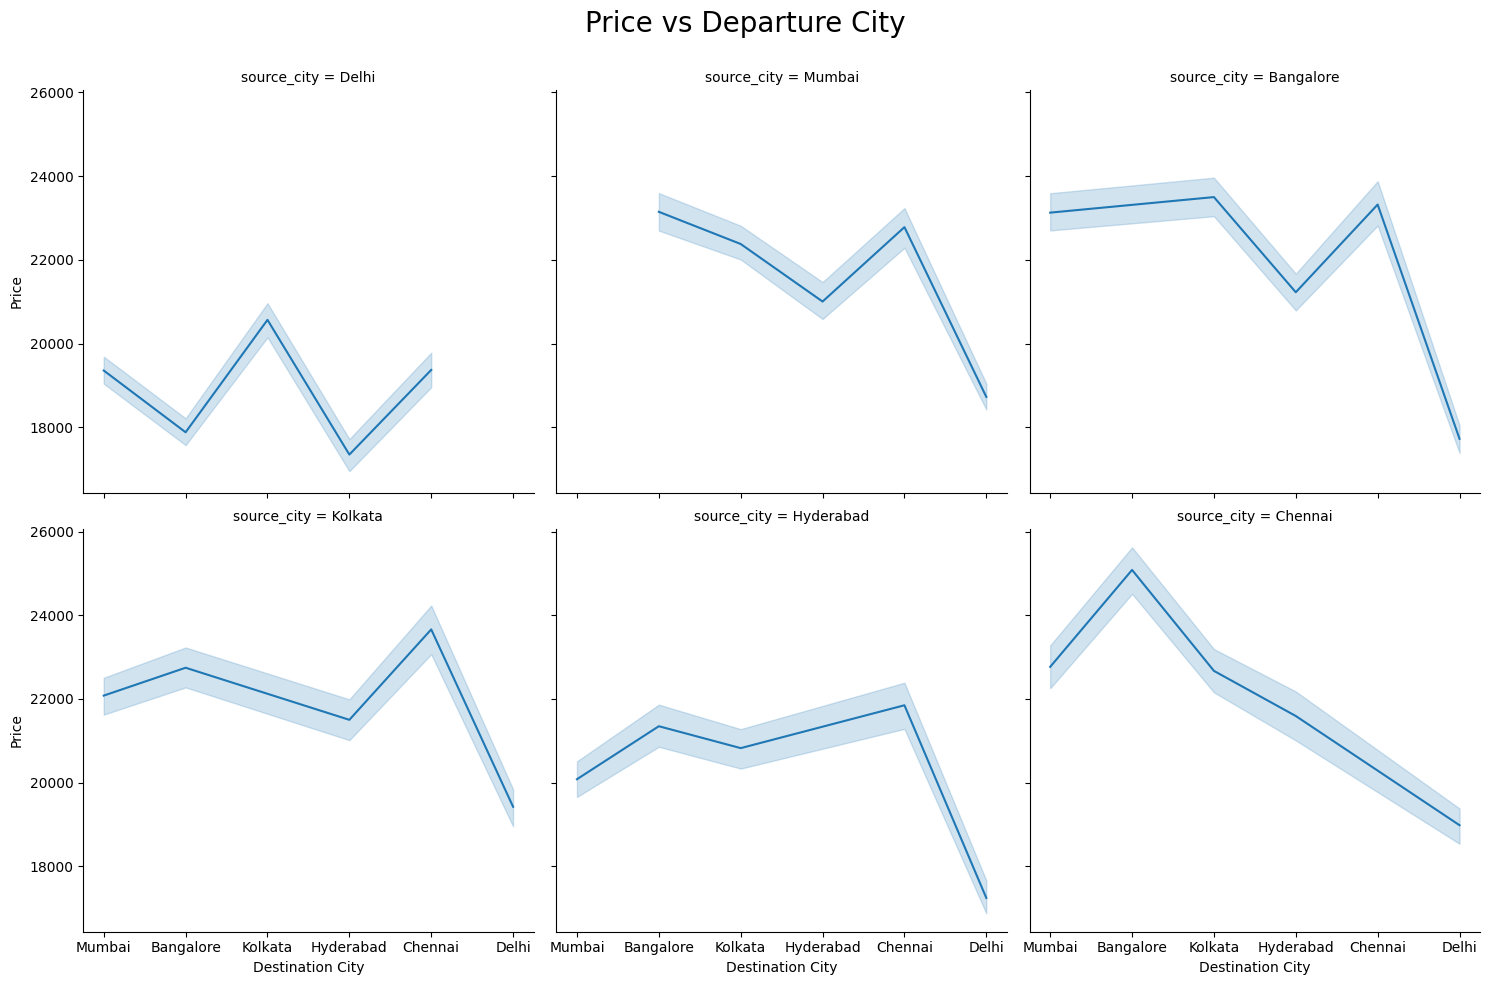

In [25]:
# price vary with different Departure city and Arrival city with relplot
plt.figure(figsize=(24,10))
ax = sns.relplot(col='source_city', y='price', x='destination_city', data=df, palette='rainbow', kind = 'line', col_wrap=3)
ax.set(xlabel='Destination City',
        ylabel='Price')
ax.fig.suptitle('Price vs Departure City', fontsize=20)
ax.fig.subplots_adjust(top=0.9)
plt.show()


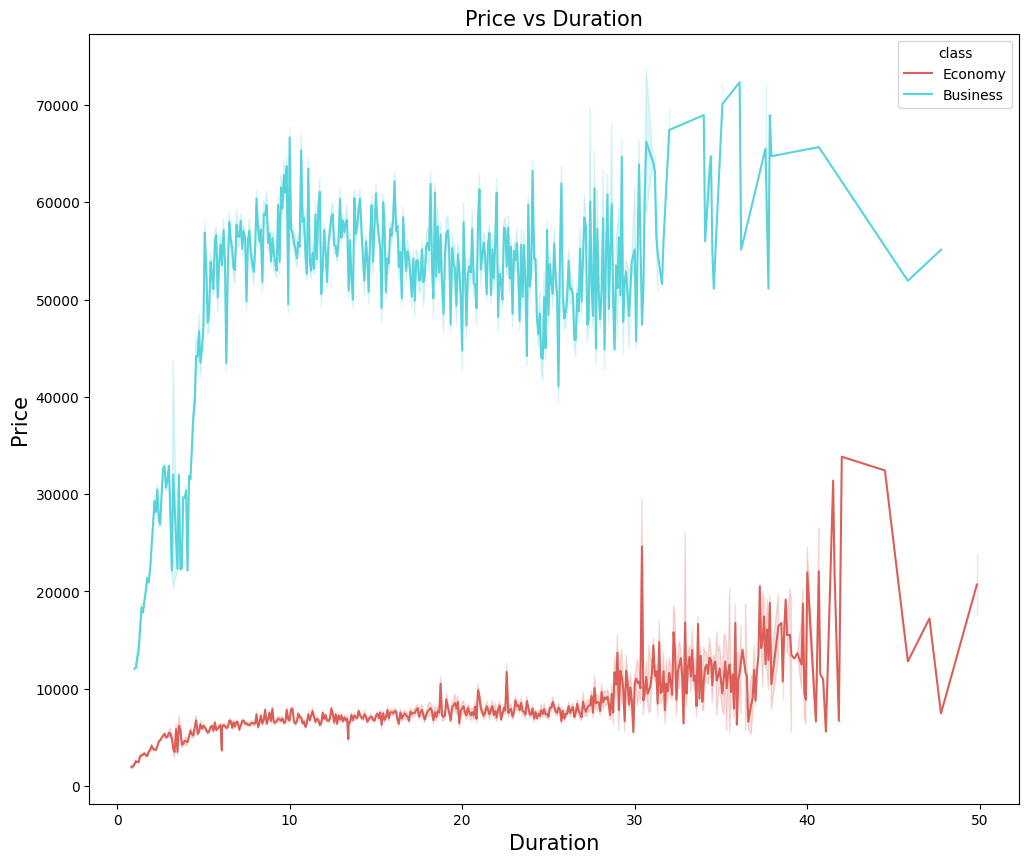

In [26]:
# price vary with flight duration
plt.figure(figsize=(12,10))
sns.lineplot(x='duration',y='price',data=df,hue='class', palette='hls')
plt.title('Price vs Duration',fontsize=15)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [27]:
# Total number of flights from one city to another
df.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count().sort_values('flight',ascending=False)

,source_city,destination_city,flight
14,Delhi,Mumbai,364
10,Delhi,Bangalore,310
13,Delhi,Kolkata,306
27,Mumbai,Delhi,282
11,Delhi,Chennai,258
29,Mumbai,Kolkata,240
25,Mumbai,Bangalore,228
1,Bangalore,Delhi,227
12,Delhi,Hyderabad,224
22,Kolkata,Delhi,185


In [28]:
# average price of different airlines from source to destination
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().sort_values('price',ascending=False).head(10)

,airline,source_city,destination_city,price
150,Vistara,Bangalore,Kolkata,35746.714874
160,Vistara,Delhi,Kolkata,35702.441732
176,Vistara,Mumbai,Kolkata,35223.862417
172,Vistara,Mumbai,Bangalore,35029.880315
151,Vistara,Bangalore,Mumbai,34961.383271
169,Vistara,Kolkata,Delhi,33792.181332
167,Vistara,Kolkata,Bangalore,33501.412807
171,Vistara,Kolkata,Mumbai,33416.101911
156,Vistara,Chennai,Mumbai,32662.127337
173,Vistara,Mumbai,Chennai,32181.946251


<Axes: xlabel='days_left', ylabel='price'>

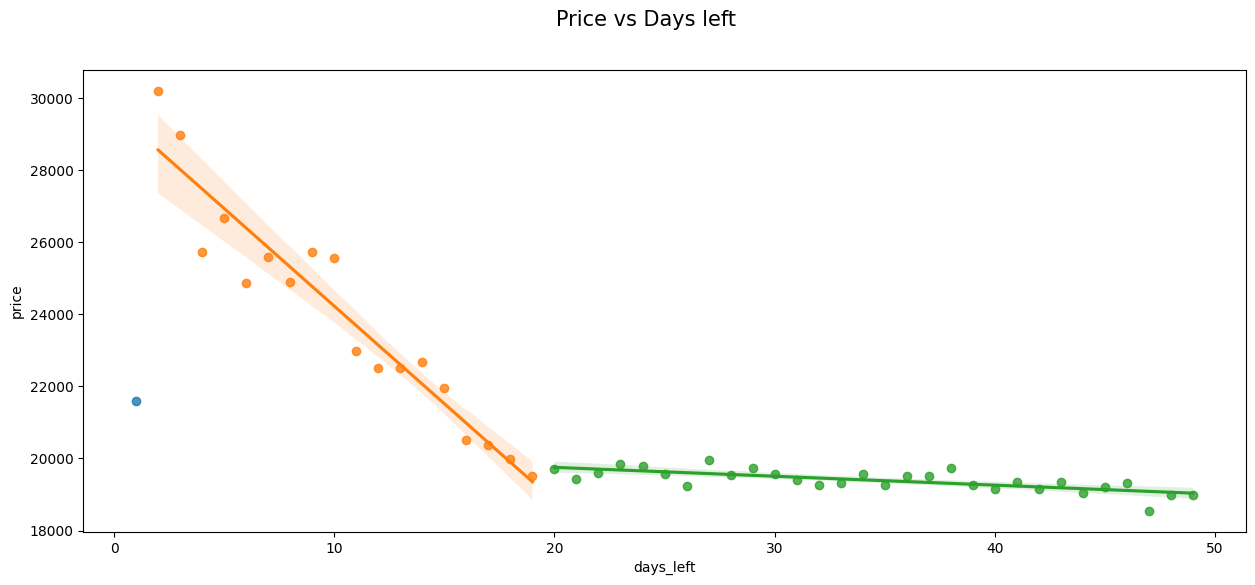

In [29]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()
# how is the price effected when the tickets are bought in just 1 or 2 days before the departure
plt.figure(figsize=(15,6)).suptitle("Price vs Days left", fontsize=15)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)


In [30]:
def preprocessing(df):
    #encoding the ordinal variables "stop" and "class"
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)

    #create the dummy variables for the nominal variables "airline", "source_city", "destination_city", "departure_time", "arrival_time"
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(['flight','airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time'],axis=1)
    return df

In [31]:
df_preprocessed = preprocessing(df)

<Axes: >

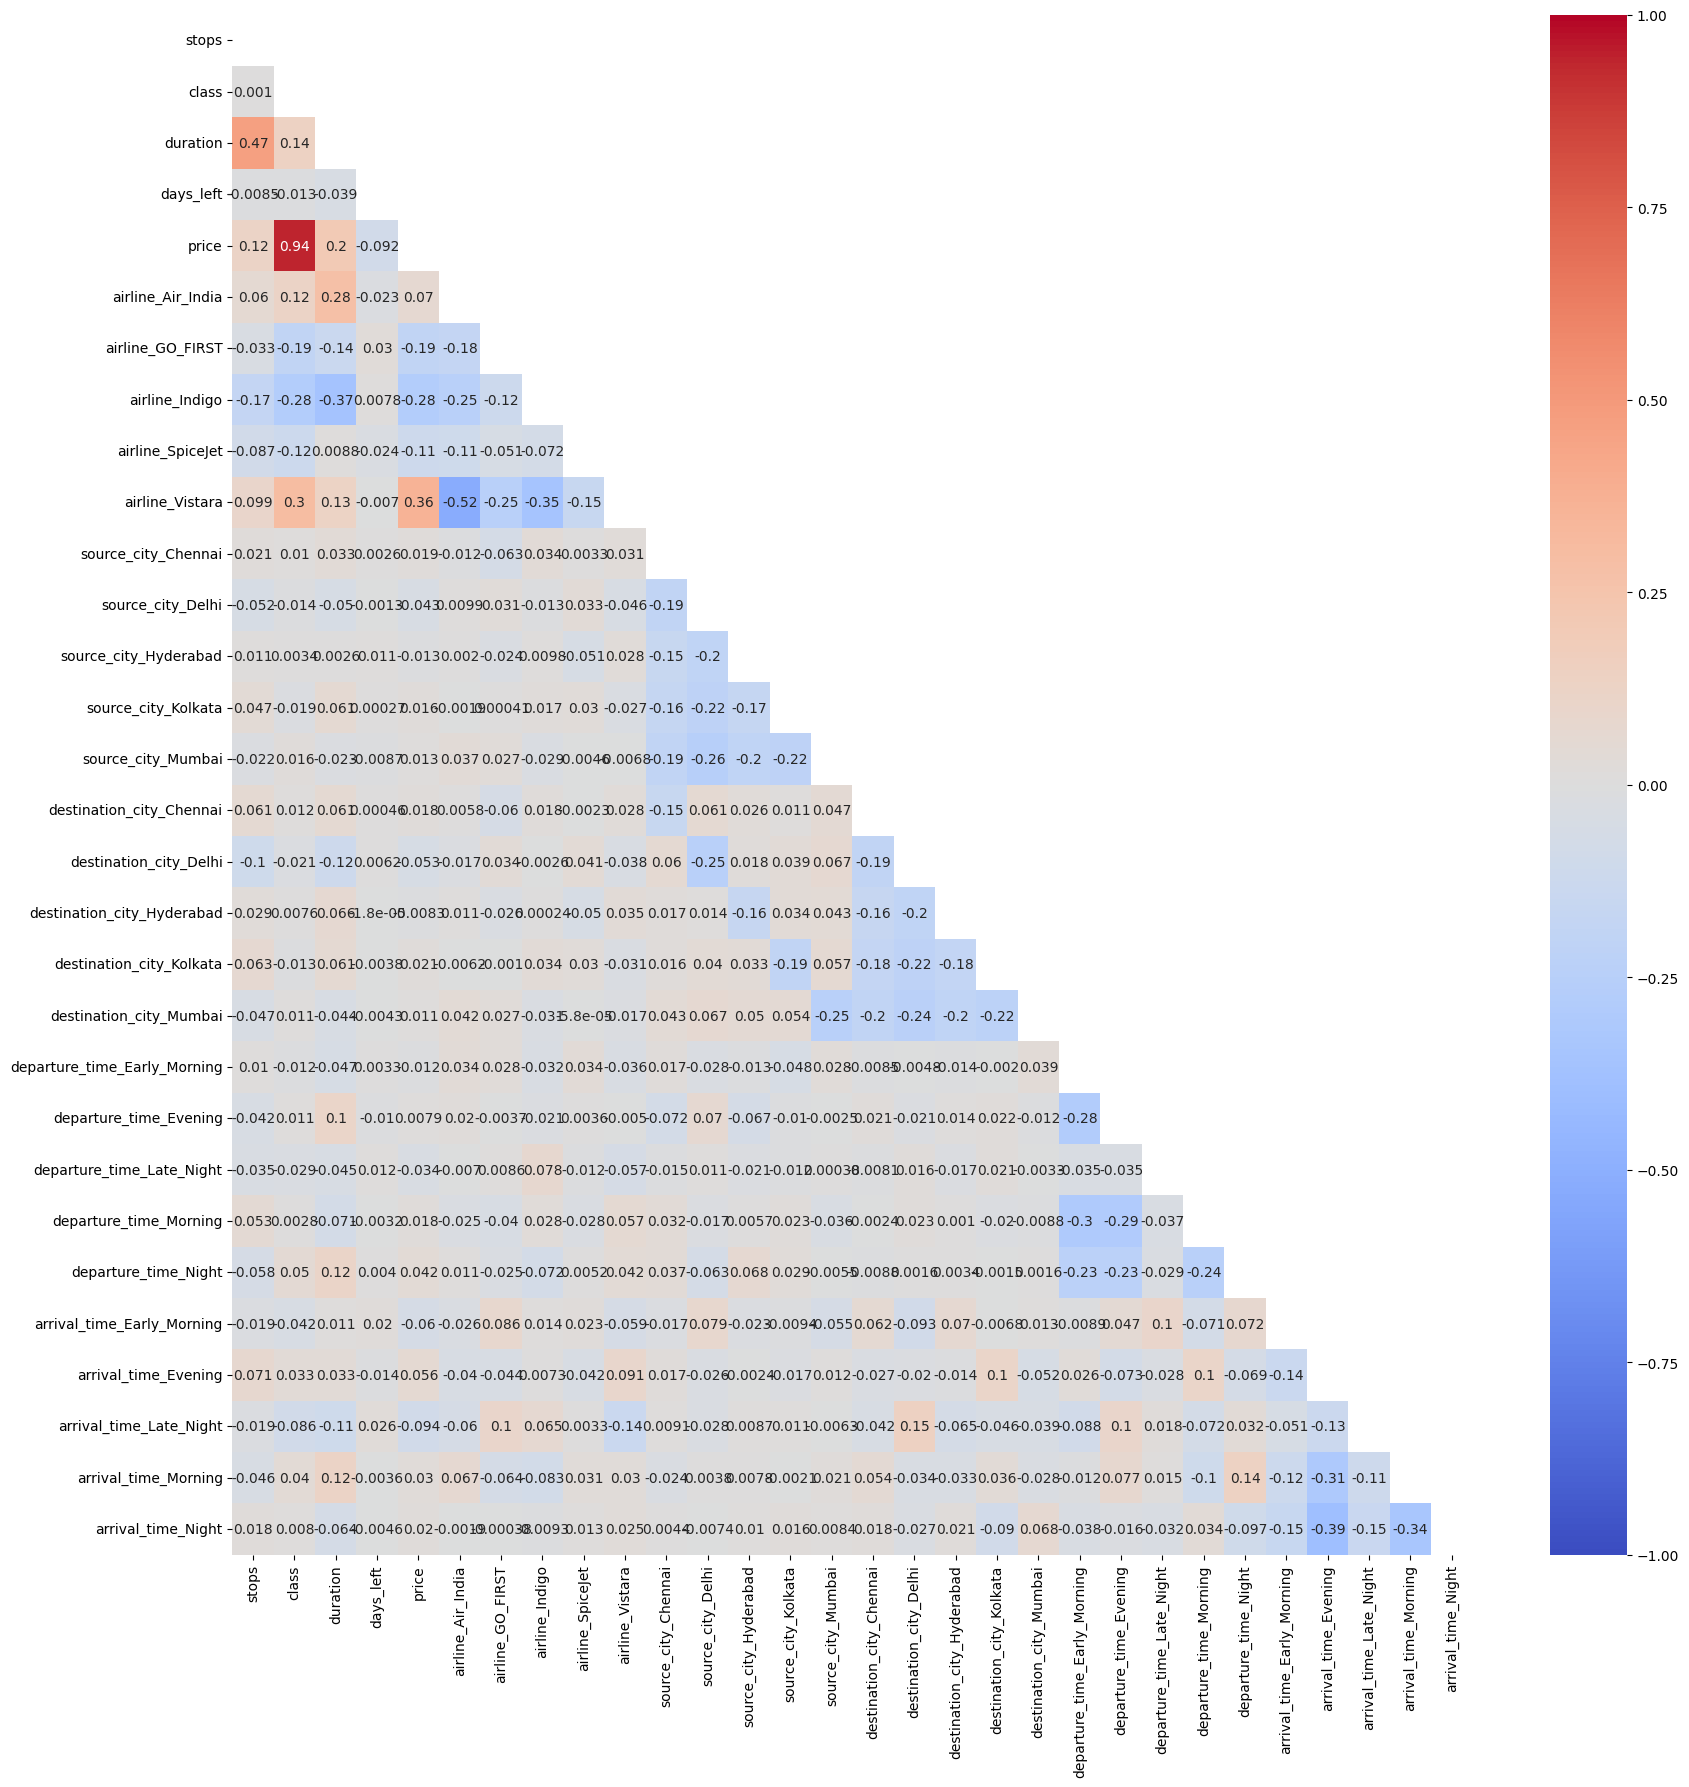

In [32]:
#heatmap
plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=bool))
sns.heatmap(df_preprocessed.corr(),annot=True,mask = mask,cmap='coolwarm', vmin=-1, vmax=1, center=0,cbar=True)

In [33]:
#drop the columns which are highly correlated
df_subset = df[['duration','airline','days_left','stops','class','price']]


In [34]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df_subset.columns:
    if df_subset[col].dtype=='object':
        df_subset[col]=le.fit_transform(df_subset[col])

In [35]:
df_subset.head()

,duration,airline,days_left,stops,class,price
0,2.17,4,1,0,0,5953
1,2.33,4,1,0,0,5953
2,2.17,0,1,0,0,5956
3,2.25,5,1,0,0,5955
4,2.33,5,1,0,0,5955


In [36]:
#storing the independent and dependent variables in X and y
X=df_subset.drop('price',axis=1)
y=df_subset['price']
X.shape,y.shape

((300153, 5), (300153,))

In [37]:
#splitting the data into training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((210107, 5), (90046, 5), (210107,), (90046,))

In [38]:
#Building the model using Plain Decision Tree Regressor, Random Forest Regressor, AdaBoost Regressor, XGBoost Regressor
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
ada=AdaBoostRegressor()
xgb=xgb.XGBRegressor()

In [39]:
#define hyperparameter grids
dt_grid = {'max_depth': [5, 8, 10], 
           'min_samples_split': [10, 20, 50]}

rf_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
           
ada_grid = {'n_estimators': [50, 100, 150],
            'learning_rate': [0.1, 1.0, 10.0]}
            
xgb_grid = {'max_depth': [5, 8, 10],
            'colsample_bytree': [0.5, 1.0]}

In [40]:
#tunning the hyperparameters of the models using GridSearchCV

grid_dt = GridSearchCV(dt, param_grid=dt_grid, cv=5)
grid_rf = GridSearchCV(rf, param_grid=rf_grid, cv=5)
grid_ada = GridSearchCV(ada, param_grid=ada_grid, cv=5)
grid_xgb = GridSearchCV(xgb, param_grid=xgb_grid, cv=5)


In [41]:
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
#predicting on the test data
y_pred=best_dt.predict(X_test)
#print the model name
print('Model name: ',best_dt)
#print the model score
from sklearn import metrics
print('Mean Absolute Error (MAE): ', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error (MSE): ', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error (RMSE): ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print('R2 score:', round(metrics.r2_score(y_test, y_pred),3))
print('Root Mean Squared Log Error (RMSLE): ', round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)),3))

#Define the function to calculate the MAPE - Mean Absolute Percentage Error
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

#Evaluation of MAPE
result = MAPE(y_test,y_pred)
print('Mean Absolute Percentage Error (MAPE): ', round(result, 2), '%')

#Calculate the adjusted R2 score
r_squared = round(metrics.r2_score(y_test, y_pred),5)
adjusted_r_squared = round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),5)
print('Adjusted R2 score:', adjusted_r_squared)

Model name:  DecisionTreeClassifier(max_depth=10, min_samples_split=20)
Mean Absolute Error (MAE):  3618.706
Mean Squared Error (MSE):  43944464.278
Root Mean Squared Error (RMSE):  6629.062
R2 score: 0.915
Root Mean Squared Log Error (RMSLE):  0.323
Mean Absolute Percentage Error (MAPE):  21.6 %
Adjusted R2 score: 0.91462


In [42]:
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
#predicting on the test data
y_pred=best_rf.predict(X_test)
#print the model name
print('Model name: ',best_rf)
#print the model score
from sklearn import metrics
print('Mean Absolute Error (MAE): ', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error (MSE): ', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error (RMSE): ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print('R2 score:', round(metrics.r2_score(y_test, y_pred),3))
print('Root Mean Squared Log Error (RMSLE): ', round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)),3))

#Define the function to calculate the MAPE - Mean Absolute Percentage Error
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

#Evaluation of MAPE
result = MAPE(y_test,y_pred)
print('Mean Absolute Percentage Error (MAPE): ', round(result, 2), '%')

#Calculate the adjusted R2 score
r_squared = round(metrics.r2_score(y_test, y_pred),5)
adjusted_r_squared = round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),5)
print('Adjusted R2 score:', adjusted_r_squared)

KeyboardInterrupt: 

In [ ]:
grid_ada.fit(X_train, y_train)
best_ada = grid_ada.best_estimator_ 
#predicting on the test data
y_pred=best_ada.predict(X_test)
#print the model name
print('Model name: ',best_ada)
#print the model score
from sklearn import metrics
print('Mean Absolute Error (MAE): ', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error (MSE): ', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error (RMSE): ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print('R2 score:', round(metrics.r2_score(y_test, y_pred),3))
print('Root Mean Squared Log Error (RMSLE): ', round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)),3))

#Define the function to calculate the MAPE - Mean Absolute Percentage Error
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

#Evaluation of MAPE
result = MAPE(y_test,y_pred)
print('Mean Absolute Percentage Error (MAPE): ', round(result, 2), '%')

#Calculate the adjusted R2 score
r_squared = round(metrics.r2_score(y_test, y_pred),5)
adjusted_r_squared = round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),5)
print('Adjusted R2 score:', adjusted_r_squared)

In [ ]:
grid_xgb.fit(X_train, y_train)
best_xgb= grid_xgb.best_estimator_
#predicting on the test data
y_pred=best_xgb.predict(X_test)
#print the model name
print('Model name: ',best_xgb)
#print the model score
from sklearn import metrics
print('Mean Absolute Error (MAE): ', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error (MSE): ', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error (RMSE): ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print('R2 score:', round(metrics.r2_score(y_test, y_pred),3))
print('Root Mean Squared Log Error (RMSLE): ', round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)),3))

#Define the function to calculate the MAPE - Mean Absolute Percentage Error
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

#Evaluation of MAPE
result = MAPE(y_test,y_pred)
print('Mean Absolute Percentage Error (MAPE): ', round(result, 2), '%')

#Calculate the adjusted R2 score
r_squared = round(metrics.r2_score(y_test, y_pred),5)
adjusted_r_squared = round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),5)
print('Adjusted R2 score:', adjusted_r_squared)

Model name:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Mean Absolute Error (MAE):  2917.37
Mean Squared Error (MSE):  25456016.779
Root Mean Squared Error (RMSE):  5045.396
R2 score: 0.951
Root Mean Squared Log Error (RMSLE):  0.246
Mean Absolute Percentage Error (MAPE):  19.36 %
Adjusted R2 score:

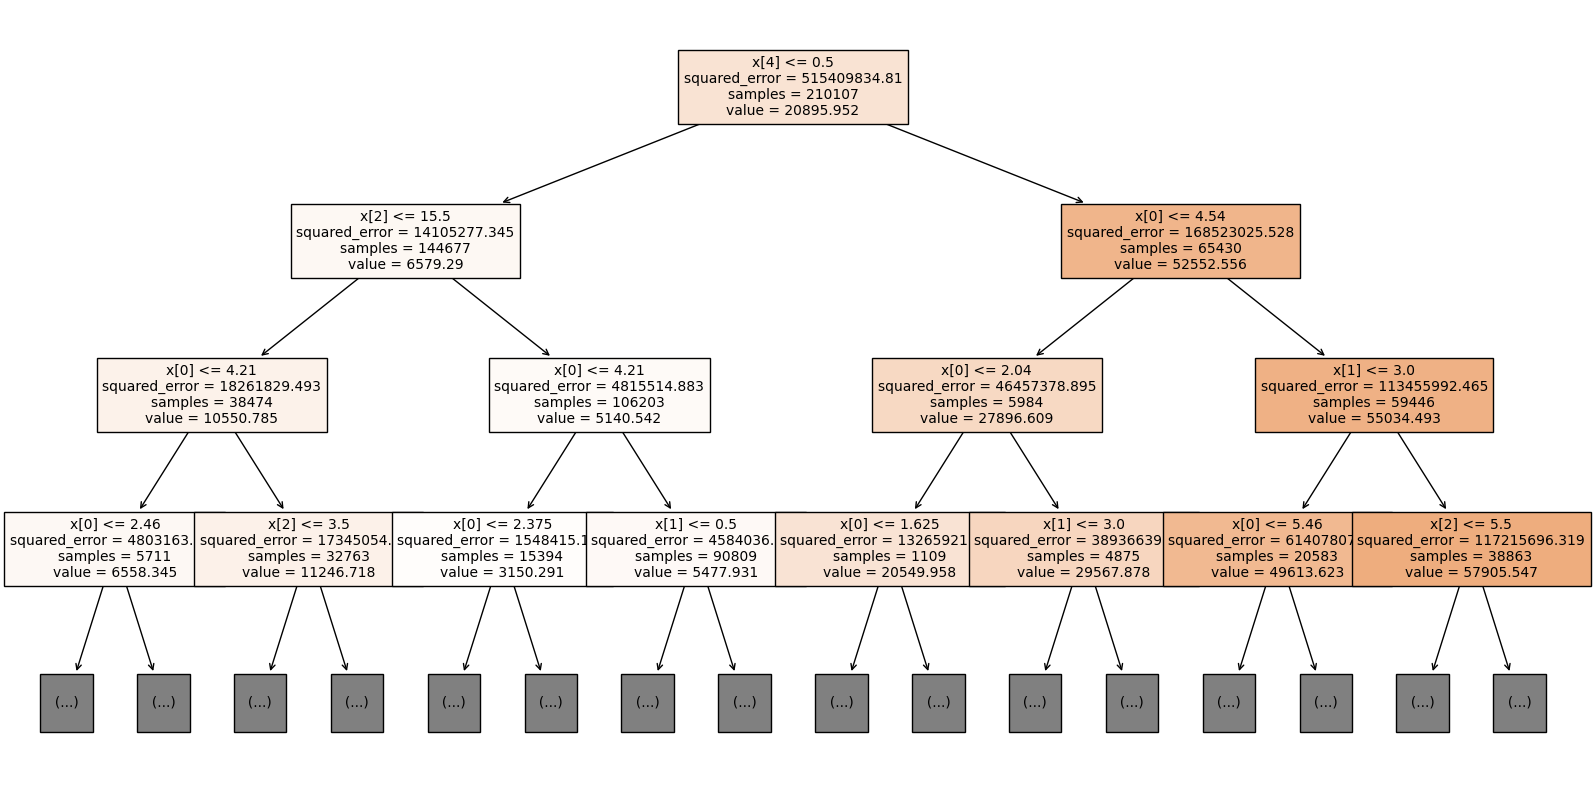

In [ ]:
#plot Decision Tree Regressor
plt.figure(figsize=(20,10))
tree.plot_tree(best_dt, filled=True, fontsize=10, max_depth=3)
plt.show()

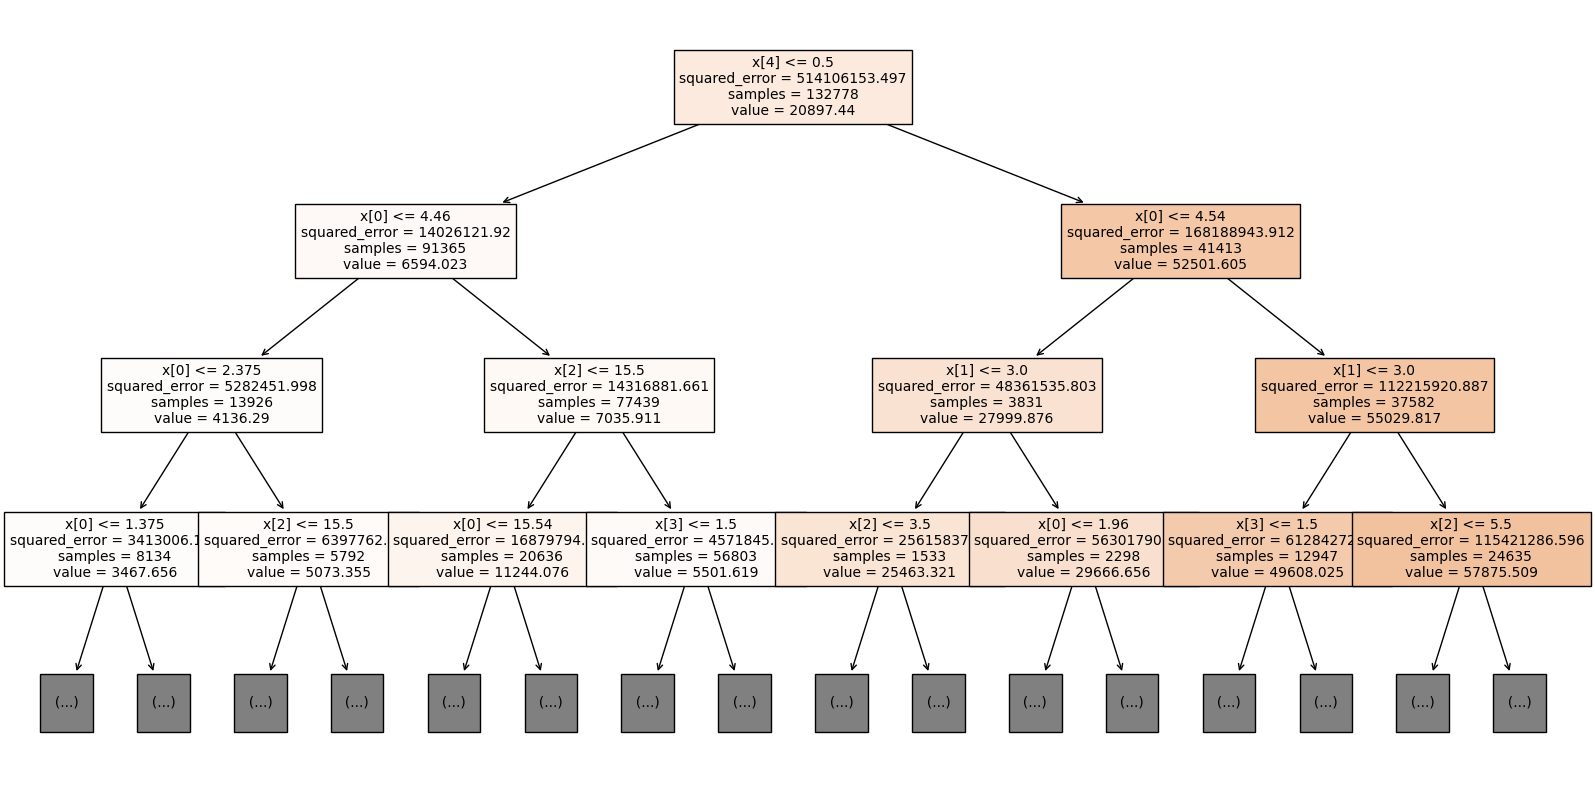

In [ ]:
#plot Random Forest Regressor
plt.figure(figsize=(20,10))
tree.plot_tree(best_rf.estimators_[0], filled=True, fontsize=10, max_depth=3)
plt.show()

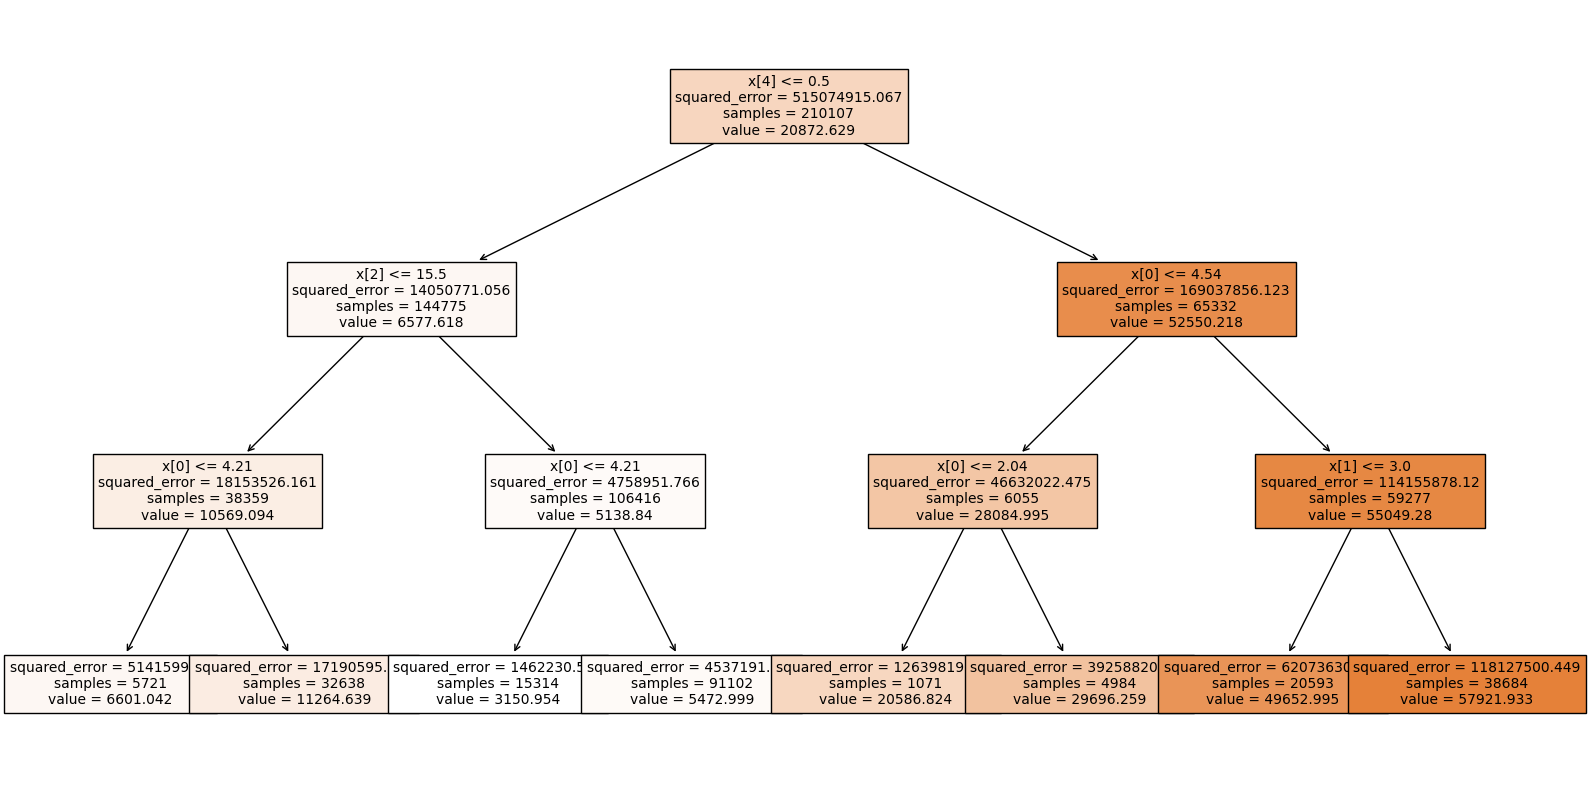

In [ ]:
#plot AdaBoost Regressor
plt.figure(figsize=(20,10))
tree.plot_tree(best_ada.estimators_[0], filled=True, fontsize=10, max_depth=3)
plt.show()

<Figure size 2000x1000 with 0 Axes>

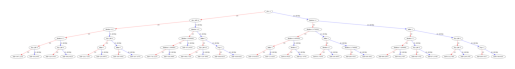

In [ ]:
# XGBoost Regressor Tree Visualization
from xgboost import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_xgb, num_trees=0)
plt.savefig('xgb_tree.png', dpi=1200)

In [ ]:
#use xgboost classifier with GridSearchCV to find the best parameters
xgb = xgb.XGBClassifier()
grid_xgb = GridSearchCV(xgb, param_grid=xgb_grid, cv=5)
grid_xgb.fit(X_train, y_train)
best_xgb= grid_xgb.best_estimator_
#predicting on the test data
y_pred=best_xgb.predict(X_test)
#print the model name
print('Model name: ',best_xgb)
#print the model score
from sklearn import metrics
print('Mean Absolute Error (MAE): ', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error (MSE): ', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error (RMSE): ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print('R2 score:', round(metrics.r2_score(y_test, y_pred),3))
print('Root Mean Squared Log Error (RMSLE): ', round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)),3))

#Define the function to calculate the MAPE - Mean Absolute Percentage Error
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

#Evaluation of MAPE
result = MAPE(y_test,y_pred)
print('Mean Absolute Percentage Error (MAPE): ', round(result, 2), '%')

#Calculate the adjusted R2 score
r_squared = round(metrics.r2_score(y_test, y_pred),5)
adjusted_r_squared = round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),5)
print('Adjusted R2 score:', adjusted_r_squared)

In [ ]:
y_pred = best_rf.predict(X_test)

# Calculate additional metrics
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall) 
print("F1 Score:", f1)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets